# ECSE 415 Assignment 4
## Author1: Bohan Wang
## Student ID1: 261023725
## Author2: Peter Zhang
## Student ID2: 26102xxxx
## Comments:
### + Library used in this assignment:
#### `numpy version: 1.26.4`
#### `scikit-image version: 0.23.2`
#### `matplotlib version: 3.8.5`


### + Run system setup for install the library
### + Please find path for the images in the `Images path` section


## Citation
```
@misc{ecse-415-a-4-24-f,
    author = {Kevin Kong},
    title = {ECSE415 Image Segmentation},
    year = {2024},
    howpublished = {\url{https://kaggle.com/competitions/ecse-415-a-4-24-f}},
    note = {Kaggle}
}


## 1 Data Preparation (10 points)
### 1.1 Download and Extract:
### 1.2 Explore the Dataset:

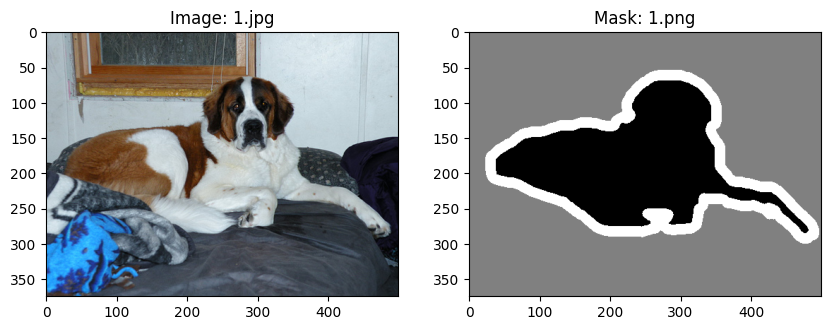

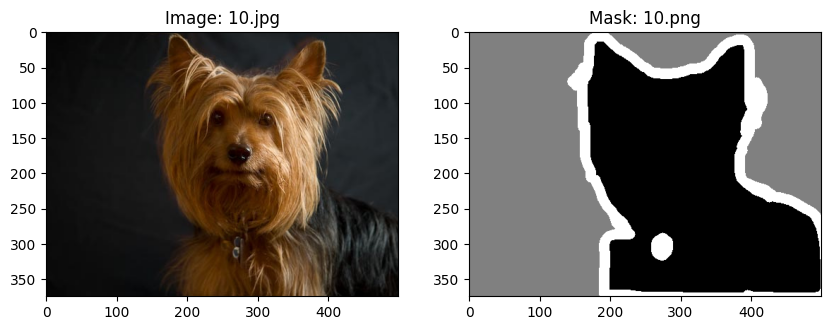

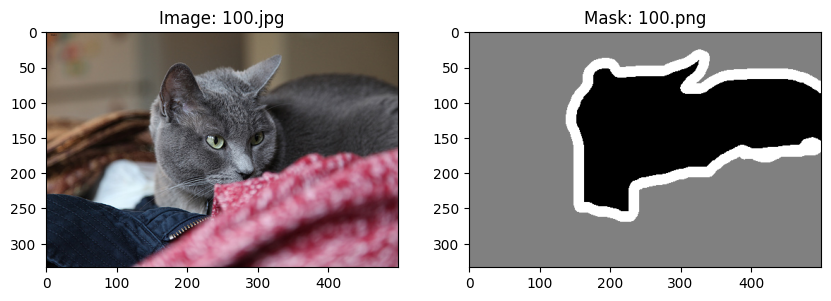

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set paths
images_path = '/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/images'
masks_path = '/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/masks'

# List image and mask files
image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

# Show first 3 images and masks
for i in range(3):
    image_file = image_files[i]
    mask_file = mask_files[i]
    
    image = mpimg.imread(os.path.join(images_path, image_file))
    mask = mpimg.imread(os.path.join(masks_path, mask_file))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title(f"Image: {image_file}")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"Mask: {mask_file}")
    plt.show()


### 1.3 Preprocess the Data:


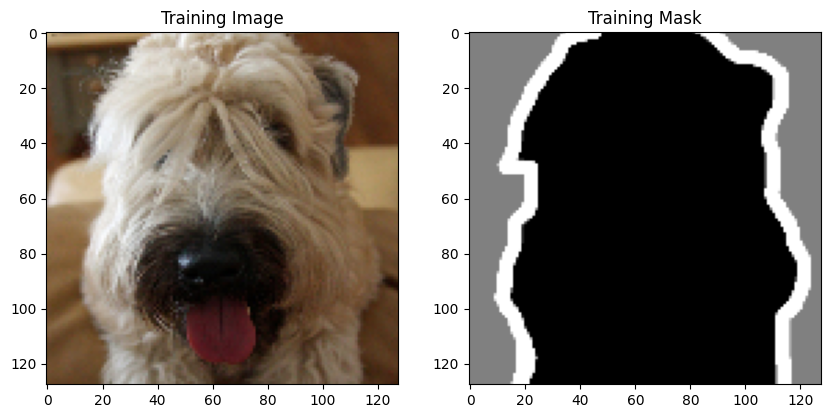

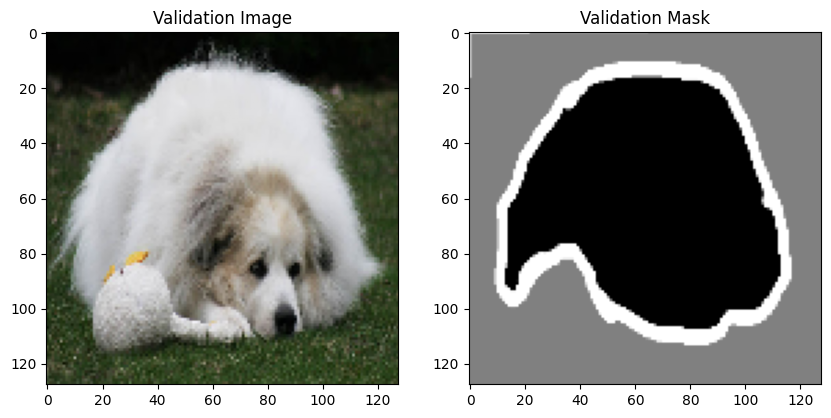

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# Function to resize and normalize images
def preprocess_image(image, size=(128, 128)):
    resized_image = cv2.resize(image, size)
    normalized_image = resized_image / 255.0
    return normalized_image

# Preprocess images and masks
preprocessed_images = [preprocess_image(mpimg.imread(os.path.join(images_path, img))) for img in image_files]
preprocessed_masks = [preprocess_image(mpimg.imread(os.path.join(masks_path, msk)), size=(128, 128)) for msk in mask_files]

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(preprocessed_images, preprocessed_masks, test_size=0.3, random_state=41)

# Display a training image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0])
plt.title("Training Image")
plt.subplot(1, 2, 2)
plt.imshow(train_masks[0], cmap='gray')
plt.title("Training Mask")
plt.show()

# Display a validation image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(val_images[0])
plt.title("Validation Image")
plt.subplot(1, 2, 2)
plt.imshow(val_masks[0], cmap='gray')
plt.title("Validation Mask")
plt.show()


In [9]:
# Output the size of the dataset
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of validation masks: {len(val_masks)}")


Number of training images: 3773
Number of validation images: 1617
Number of training masks: 3773
Number of validation masks: 1617


## 2 Baseline Methods (10 points)


In [11]:
from sklearn.mixture import GaussianMixture
from skimage.color import rgb2lab

# Function to perform Gaussian Mixture Model segmentation
def gmm_segmentation(image, n_components=3, random_state=42):
    lab_image = rgb2lab(image)
    reshaped_image = lab_image.reshape((-1, 3))
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.fit(reshaped_image)
    segmented_image = gmm.predict(reshaped_image)
    segmented_image = segmented_image.reshape(image.shape[:2])
    return segmented_image


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Function to evaluate the performance of the GMM segmentation
def evaluate_segmentation(true_masks, pred_masks):
    accuracies = []
    for true_mask, pred_mask in zip(true_masks, pred_masks):
        true_mask_flat = true_mask.flatten()
        pred_mask_flat = pred_mask.flatten()
        if len(np.unique(true_mask_flat)) > 1 and len(np.unique(pred_mask_flat)) > 1:
            accuracies.append(accuracy_score(true_mask_flat, pred_mask_flat))
        else:
            print("Skipping mask with insufficient class variety")
    return np.mean(accuracies)

# Perform segmentation on validation images
val_segmented_masks = [gmm_segmentation(image) for image in val_images[:100]]

# Evaluate the performance
gmm_accuracy = evaluate_segmentation(val_masks, val_segmented_masks)
print(f"GMM Segmentation Accuracy on Validation Set: {gmm_accuracy:.4f}")


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets